<a href="https://colab.research.google.com/github/cemredogan-ceng/BUSI/blob/main/busi_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install necessary libraries
!pip install segmentation-models-pytorch
!pip install torch torchvision
!pip install scikit-learn

# Import libraries
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image, ImageEnhance
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Mount Google Drive
drive.mount('/content/drive')

# Dataset directory
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'

# Custom Dataset Class
class BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, classes=['benign', 'malignant'], transform_image=None, transform_mask=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.image_paths = []
        self.mask_paths = []

        # Load image and mask paths
        for cls in self.classes:
            image_dir = os.path.join(root_dir, cls)
            for filename in os.listdir(image_dir):
                if filename.endswith(".png") and "_mask" not in filename:
                    image_path = os.path.join(image_dir, filename)
                    mask_path = os.path.join(image_dir, filename.replace(".png", "_mask.png"))
                    self.image_paths.append(image_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale mask

        # Apply data augmentations
        if np.random.rand() > 0.5:
            image = ImageEnhance.Contrast(image).enhance(1.5)  # Increase contrast
        if np.random.rand() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)  # Horizontal flip
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        if np.random.rand() > 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)  # Vertical flip
            mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Dataset initialization
dataset = BreastUltrasoundDataset(
    root_dir=base_dir,
    classes=['benign', 'malignant'],
    transform_image=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
    transform_mask=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# Define the AlexNet-based segmentation model
class AlexNetSegmentationModel(nn.Module):
    def __init__(self, weights=AlexNet_Weights.IMAGENET1K_V1, num_classes=1):
        super(AlexNetSegmentationModel, self).__init__()
        # Load pretrained AlexNet model
        self.encoder = alexnet(weights=weights)

        # Remove the classification head (fc layers) to preserve spatial dimensions
        self.encoder.classifier = nn.Identity()

        # Decoder head
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),  # Final upsampling to match input size
            nn.Conv2d(32, num_classes, kernel_size=1),  # Final output
        )

    def forward(self, x):
        # Resize input to match AlexNet's expected input size
        x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)

        # Encoder features
        features = self.encoder.features(x)

        # Decoder to generate segmentation map
        decoded = self.decoder(features)

        # Resize the decoder output to match the target mask size (256x256)
        decoded = F.interpolate(decoded, size=(256, 256), mode="bilinear", align_corners=True)

        return decoded

# Initialize the model
model = AlexNetSegmentationModel(weights=AlexNet_Weights.DEFAULT, num_classes=1).cuda()

# Loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_function(predictions, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/My Drive/Dataset_BUSI_with_GT/alexnet_segmentation_model.pth')


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=3d8406a6a1a6f93f0faf3374f999bc9d30cf642ba6761799ec4a2b218a19ae6f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=f98920fae3a54030214a5b576c930a73d39e5720b020782fbdb9b1398860231b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

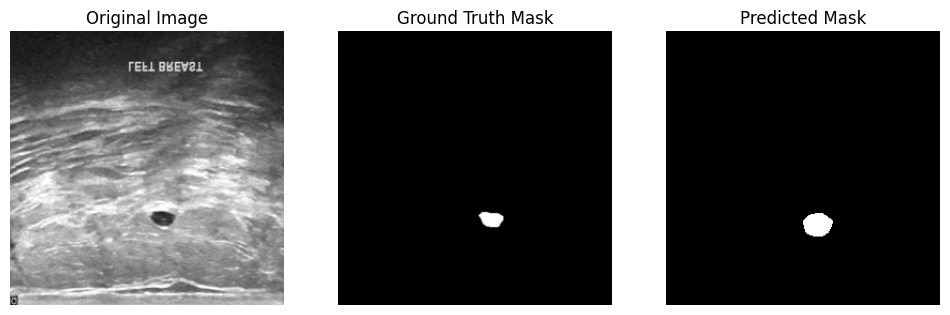

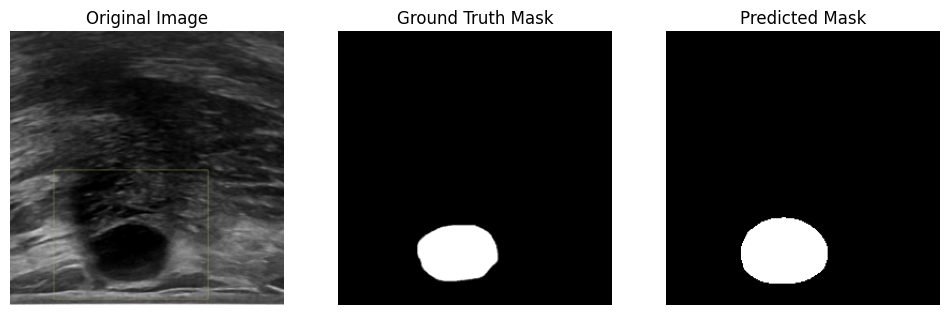

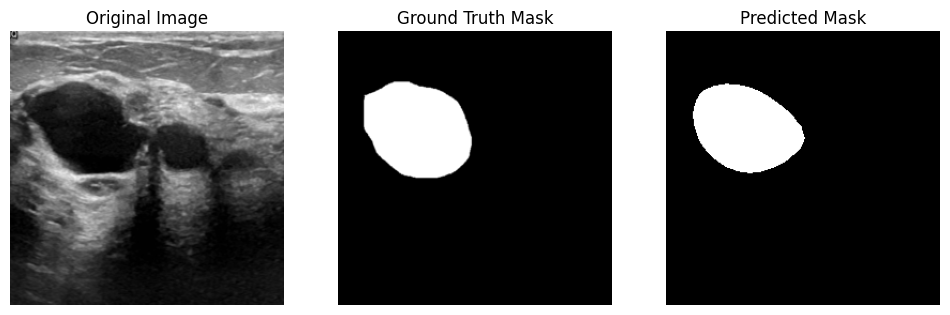

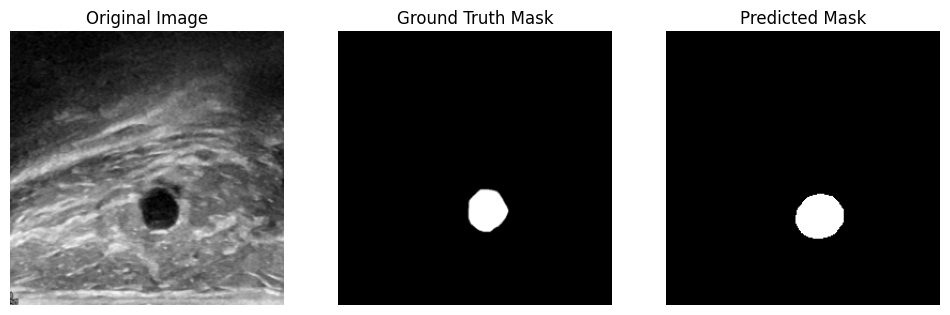

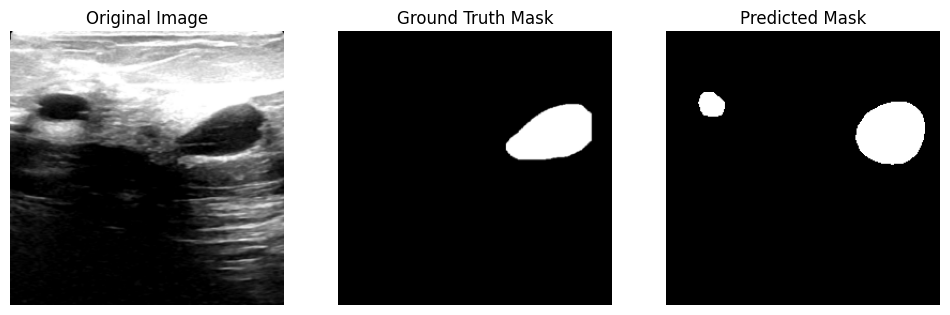

In [3]:
import matplotlib.pyplot as plt

def visualize_predictions(dataset, model, num_samples=5):
    """
    Visualize original images, ground truth masks, and predicted masks.

    Args:
    - dataset: Dataset object containing images and masks.
    - model: Trained segmentation model.
    - num_samples: Number of samples to visualize.
    """
    model.eval()  # Set model to evaluation mode

    for i in range(num_samples):
        image, mask = dataset[i]  # Get an image and its ground truth mask
        image_input = image.unsqueeze(0).cuda()  # Add batch dimension and move to GPU

        with torch.no_grad():
            # Get model prediction
            prediction = model(image_input)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Sigmoid and move to CPU
            prediction_binary = (prediction > 0.5).astype(np.uint8)  # Binarize prediction

        # Plot original image, ground truth mask, and predicted mask
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0).numpy())  # Convert CHW to HWC for plotting
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().numpy(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(prediction_binary, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()
# Modelin tahminlerini görselleştir
visualize_predictions(dataset, model, num_samples=5)

In [4]:
# Evaluation Function
def evaluate_model(dataset, model, num_samples=100):
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, mask = dataset[i]
            image = image.unsqueeze(0).cuda()  # Add batch dimension
            mask = mask.squeeze().cpu().numpy()  # Ground truth mask in NumPy format

            # Get model prediction
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Apply sigmoid activation

            # Binarize the prediction with a threshold of 0.5
            prediction_binary = (prediction > 0.5).astype(np.uint8)

            # Flatten the arrays for metric computation
            all_preds.append(prediction_binary.flatten())
            all_masks.append(mask.flatten())

    # Concatenate all predictions and masks
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks).astype(np.uint8)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    # Dice score
    intersection = np.logical_and(y_true, y_pred).sum()
    dice_score = (2.0 * intersection) / (y_true.sum() + y_pred.sum() + 1e-6)

    # IoU (Jaccard Index)
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / (union + 1e-6)

    # Print metrics
    print("Evaluation Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Dice Score: {dice_score:.4f}")
    print(f"  IoU (Jaccard Index): {iou:.4f}")

# Evaluate the entire dataset
evaluate_model(dataset, model, num_samples=len(dataset))

Evaluation Metrics:
  Accuracy: 0.9605
  Precision: 0.7712
  Recall: 0.7919
  F1 Score: 0.7815
  Dice Score: 0.7815
  IoU (Jaccard Index): 0.6413
